## EDA of num dataset (business calls and sms data)

Examine data from `num` dataset and decide what extra features can we get.


In [2]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from utils import eda
from utils import io
import utils.model_lgb as model_lgb
import project.project_api as project_api
import project.bnum as bnum
import plotly.express as px
import seaborn as sns

In [3]:
RANDOM_SEED = 42
TARGET_KEY = "target"
CLASS_NUM = 5

Dictionary:

- `abon_id` — subscriber id
- `bnum` — Business number name that was contacted with subscriber
- `call_cnt_out` — outgoing calls count
- `call_cnt_in` — incoming calls count
- `call_dur_out` — outgoing calls duration
- `call_dur_in` — incoming calls duration
- `cnt_sms_out` — outgoing sms count
- `cnt_sms_in` — incoming sms count


In [4]:
df_train_targets = pd.read_parquet(
    "./data/train_fe/",
    columns=[TARGET_KEY],
)

<div class="alert alert-block alert-warning">
SMS count have fractional part. This is because of data obfuscation
</div>


In [5]:
df_train_num = pd.read_parquet("./data/train_num")
df_train_num = df_train_num.merge(
    df_train_targets,
    how="left",
    left_index=True,
    right_index=True,
)

print(df_train_num.info())
df_train_num

<class 'pandas.core.frame.DataFrame'>
Index: 803268 entries, 1525928 to 132551440
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bnum          803268 non-null  string 
 1   call_cnt_out  803268 non-null  float16
 2   call_cnt_in   803268 non-null  float16
 3   call_dur_out  803268 non-null  float16
 4   call_dur_in   803268 non-null  float16
 5   cnt_sms_out   803268 non-null  float16
 6   cnt_sms_in    803268 non-null  float16
 7   target        803268 non-null  int8   
dtypes: float16(6), int8(1), string(1)
memory usage: 19.2 MB
None


,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,target
abon_id,,,,,,,,
1525928,380445990777,1.480469,0.000000,24.984375,0.000000,0.000000,0.000000,4
1525928,380672368404,3.589844,0.000000,27.671875,0.000000,0.000000,0.000000,4
1525928,380977770109,3.589844,2.207031,29.750000,28.640625,0.000000,0.000000,4
1525928,chokolovka,0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,4
1525928,dsns ukr,0.000000,0.000000,0.000000,0.000000,0.000000,3.589844,4
...,...,...,...,...,...,...,...,...
132550466,4567890,0.000000,0.000000,0.000000,0.000000,1.480469,0.000000,3
132550466,facebook,0.000000,0.000000,0.000000,0.000000,0.000000,2.921875,3
132550466,telegram,0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,3


<div class="alert alert-block alert-info">
We should pay attention that we have no calls/sms data for some of the subscribers and therefore we won't be able to make predictions for such subscribers.
</div>


In [6]:
df_abons_without_bnums = df_train_targets.index.difference(df_train_num.index)

print(
    f"Subscribers without bnum data: {len(df_abons_without_bnums)} ({len(df_abons_without_bnums)/len(df_train_targets)*100:.2f}%)"
)

Subscribers without bnum data: 35118 (23.90%)


In [7]:
# expose index as column
df_train_num["abon_id"] = df_train_num.index
df_train_num = df_train_num.reset_index(drop=True)

In [8]:
eda.print_missing(df_train_num)

Missing values report:
No missing values found!


,Total,Rate


In [9]:
eda.print_uniq(df_train_num)

Unique values report:
                uniq      rate
target             5  0.000006
cnt_sms_out       63  0.000078
call_cnt_in       93  0.000116
call_cnt_out      99  0.000123
cnt_sms_in       314  0.000391
call_dur_in     1191  0.001483
call_dur_out    1491  0.001856
bnum           31838  0.039636
abon_id       111835  0.139225
Total rows: 803268


## Derive additional features from available data


Group dataset by `abon_id` and aggregate some additional features. We will introduce some more feature when we will process data on bnum level.

In [10]:
df_bnum_extra_fe = bnum.collect_extra_fe(df_train_num)
df_bnum_extra_fe

Mem. usage decreased to  5.12 Mb (40.0% reduction)


,total_cnt_sms_out,total_cnt_sms_in,total_call_cnt_in,total_call_cnt_out,total_call_dur_in,total_call_dur_out,total_call_cnt,total_call_dur,total_cnt_sms,avg_cnt_sms,avg_call_dur_out,avg_call_dur_in,avg_call_dur,sms_per_call_cnt,avg_sms_per_call_dur,total_bnum
abon_id,,,,,,,,,,,,,,,,
1525928,0.000000,26.796875,2.207031,8.656250,28.640625,82.375000,10.867188,111.062500,26.796875,1.914062,9.515625,12.976562,10.218750,2.465852,0.187313,14
1530471,0.000000,10.765625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.765625,2.691406,0.000000,0.000000,0.000000,inf,inf,4
1541528,0.000000,21.859375,0.000000,5.882812,0.000000,110.312500,5.882812,110.312500,21.859375,2.427734,18.750000,0.000000,18.750000,3.715139,0.129502,9
1543056,2.207031,10.007812,0.000000,1.480469,0.000000,5.324219,1.480469,5.324219,12.218750,2.443359,3.595703,0.000000,3.595703,8.250660,0.679299,5
1545231,0.000000,2.207031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.207031,2.207031,0.000000,0.000000,0.000000,inf,inf,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132391381,1.480469,34.312500,0.000000,1.480469,0.000000,25.625000,1.480469,25.625000,35.781250,3.974609,17.312500,0.000000,17.312500,24.166227,0.229668,9
132442930,1.480469,12.546875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.031250,3.507812,0.000000,0.000000,0.000000,inf,inf,4
132486100,0.000000,2.921875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.921875,2.921875,0.000000,0.000000,0.000000,inf,inf,1


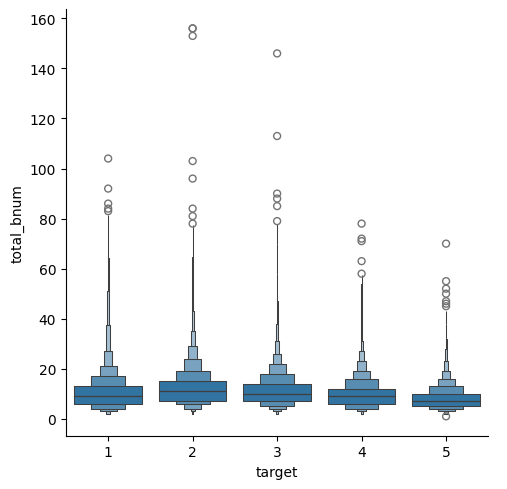

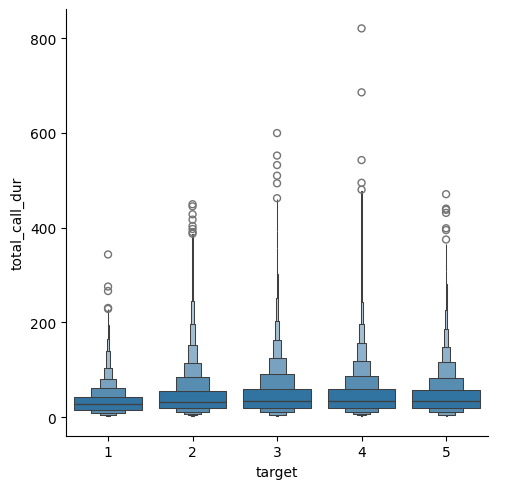

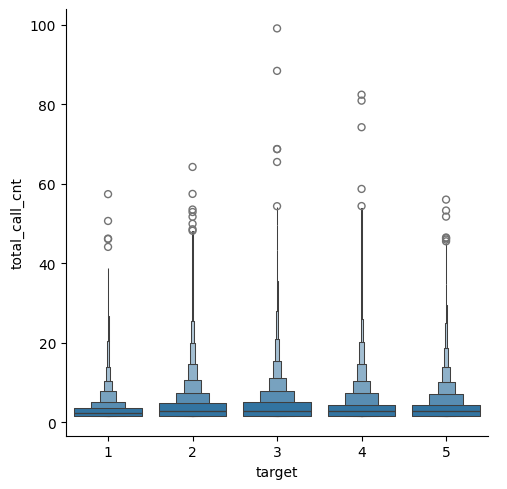

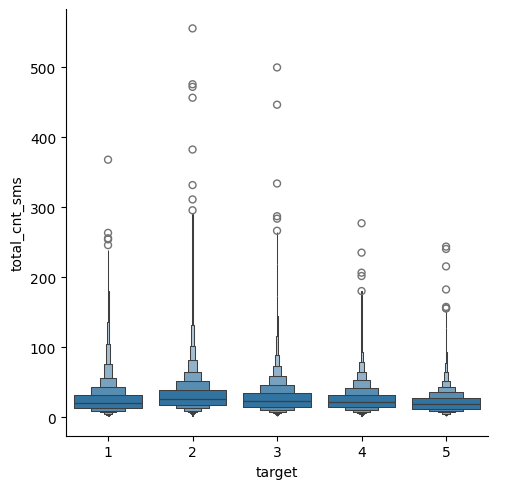

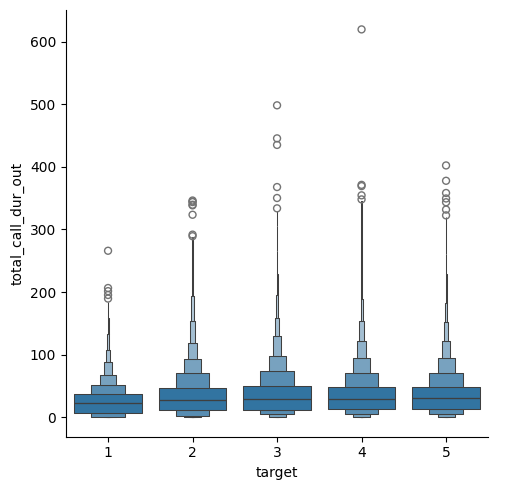

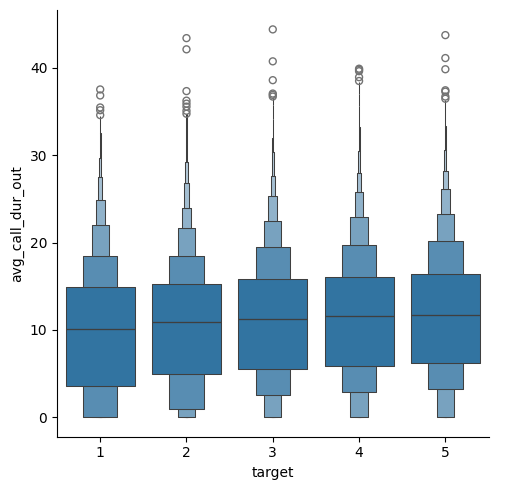

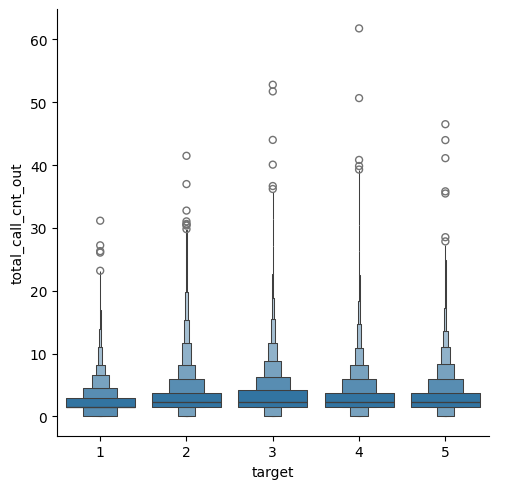

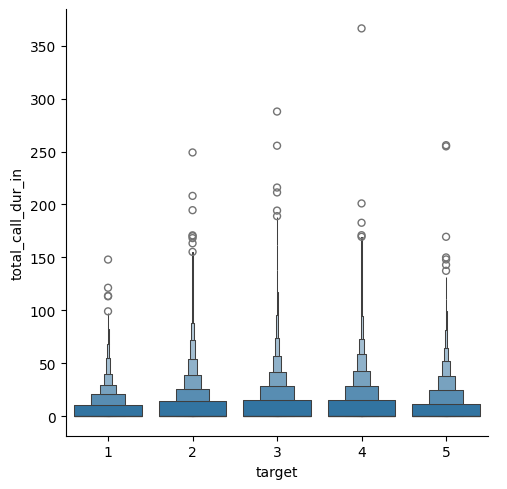

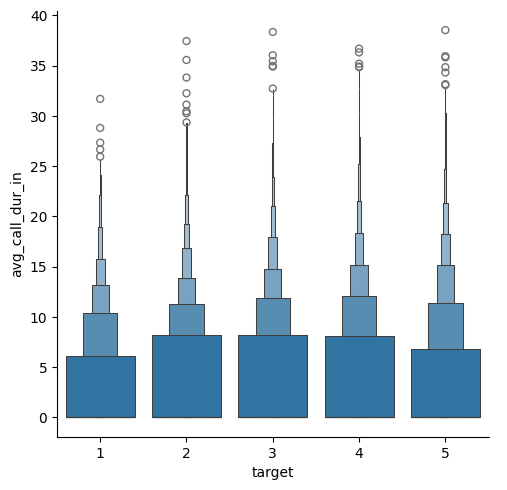

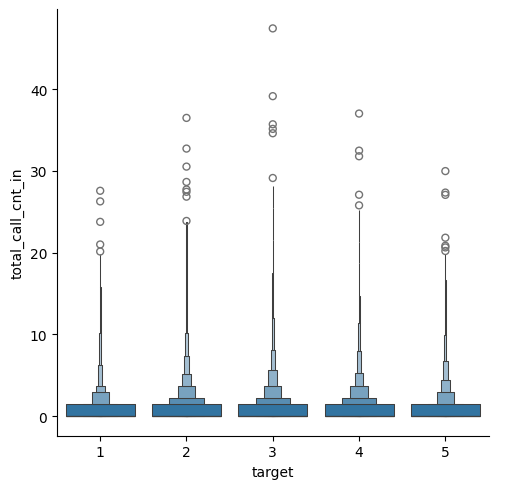

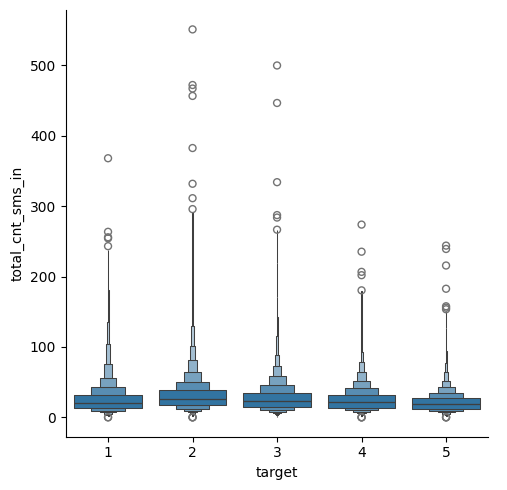

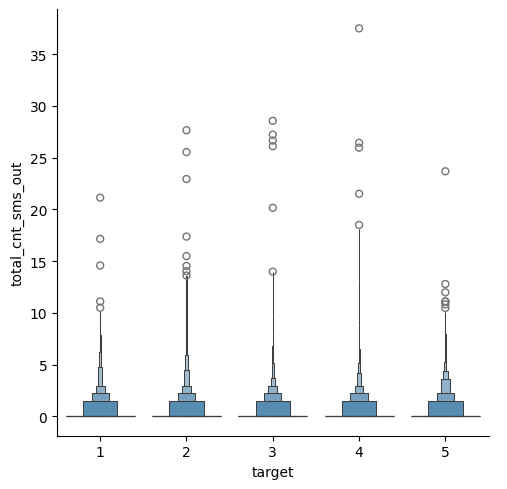

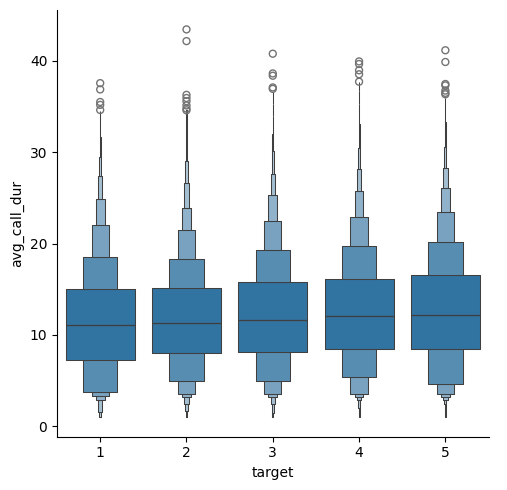

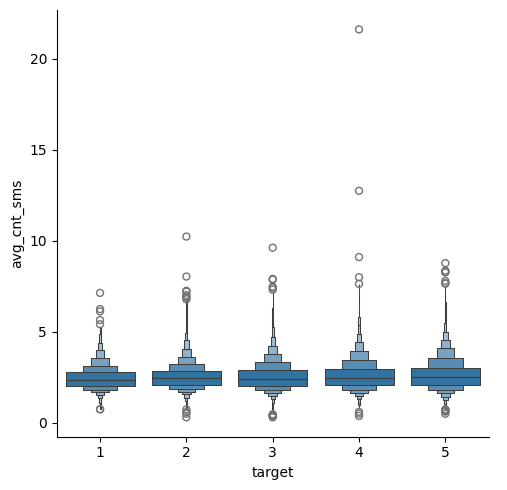

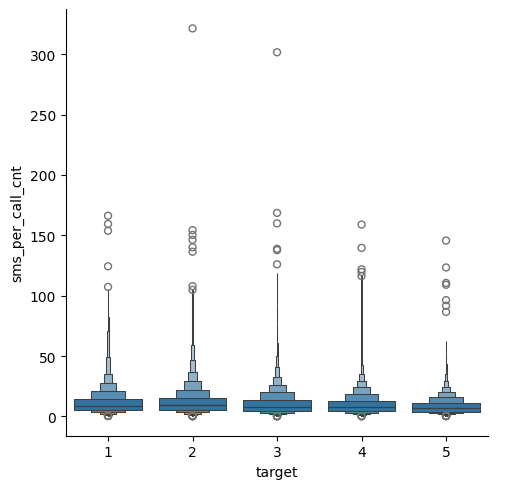

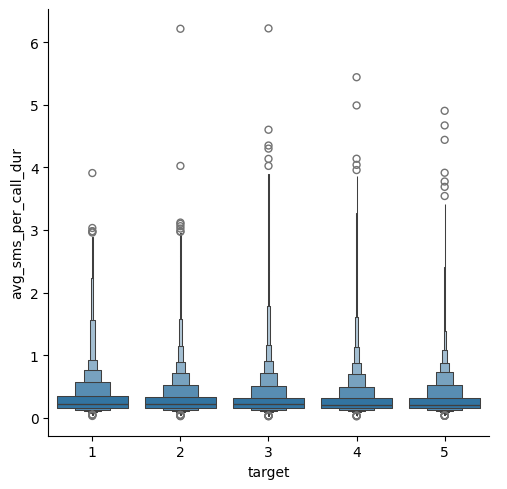

In [11]:
def visualize_abon_stats():
    df = df_bnum_extra_fe.merge(
        df_train_targets,
        how="left",
        left_index=True,
        right_index=True,
    )

    # drop subscribers without activity
    df = df[
        (df["total_bnum"] > 0)
        & (df["total_call_dur"] > 0)
        & (df["total_call_cnt"] > 0)
        & (df["total_cnt_sms"] > 0)
    ]

    sns.catplot(data=df, x=TARGET_KEY, y="total_bnum", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_call_dur", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_call_cnt", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_cnt_sms", kind="boxen")

    sns.catplot(data=df, x=TARGET_KEY, y="total_call_dur_out", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="avg_call_dur_out", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_call_cnt_out", kind="boxen")

    sns.catplot(data=df, x=TARGET_KEY, y="total_call_dur_in", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="avg_call_dur_in", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_call_cnt_in", kind="boxen")

    sns.catplot(data=df, x=TARGET_KEY, y="total_cnt_sms_in", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="total_cnt_sms_out", kind="boxen")

    sns.catplot(data=df, x=TARGET_KEY, y="avg_call_dur", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="avg_cnt_sms", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="sms_per_call_cnt", kind="boxen")
    sns.catplot(data=df, x=TARGET_KEY, y="avg_sms_per_call_dur", kind="boxen")


visualize_abon_stats()

There is no clear relation between target and newly created features but `total_bnum` looks to be promising for upper age category. We can also use other features to isolate lower age category and probably the middle one. Lets leave them in dataset.


<Axes: xlabel='bnum_id', ylabel='target'>

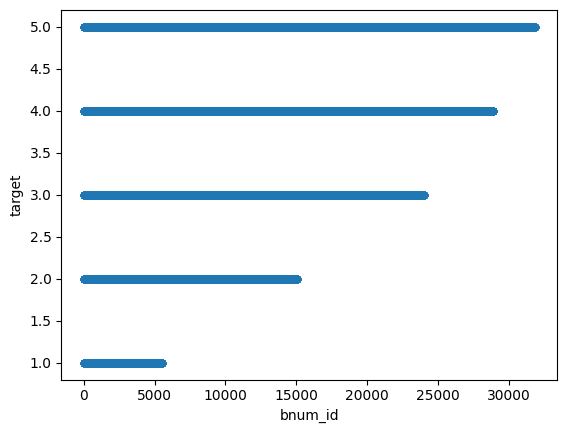

In [12]:
df_sorted = df_train_num.sort_values(by=[TARGET_KEY])
id_map = {}


def index_bnum(bnum):
    if not (bnum in id_map):
        id_map[bnum] = len(id_map) + 1

    return id_map[bnum]


df_sorted["bnum_id"] = df_sorted["bnum"].apply(index_bnum)

df_sorted.plot.scatter(x="bnum_id", y=TARGET_KEY)

## Clean up dataset

We have almost 32k business numbers in dataset. Lets examine whether we can reduce the amount of numbers to take care of.


Let's look the distribution of business numbers across subscribers and particular target groups. The hypothesis is that there should be some bnums that are more common for some group of subscribers while is not common for the other. Therefore we don't want to examine bnums that are used only by several subscribers and bnums that are used by majority of subscribers.


In [13]:
bins = [
    0,
    2,
    5,
    10,
    15,
    20,
    30,
    50,
    100,
    500,
    1000,
    2000,
    5000,
    10000,
    20000,
    30000,
    100000,
]

count, division = np.histogram(
    df_train_num.groupby("bnum")["abon_id"].count().reset_index(name="count")["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_bnum,bnum_count
0,2,16308
1,5,8854
2,10,2790
3,15,1040
4,20,552
5,30,542
6,50,564
7,100,453
8,500,541
9,1000,104


In [14]:
mean_target_counts_per_bnum = (
    df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["bnum", "count"]]
    .groupby("bnum")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_bnum["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_target_per_bnum,bnum_count
0,2,24044
1,5,5504
2,10,1035
3,15,352
4,20,148
5,30,205
6,50,171
7,100,185
8,500,152
9,1000,18


Additionally let's examine the tail of distribution:


In [15]:
with pd.option_context("display.max_rows", None):
    print(
        mean_target_counts_per_bnum[
            mean_target_counts_per_bnum["count"] >= 2000
        ].sort_values(by="count", ascending=False)
    )

             bnum    count
21822    dsns ukr  14523.2
30524     ukraine  13406.8
26684  novaposhta   4609.0
27733  privatbank   4412.8
27063  oschadbank   2765.0
21889    e-health   2612.0


Two or five subscribers per group seems not that significant, even 10 and 15. This way we will drop the major part of data that will unlikely have any value for the model.

We will also drop `dsns ukr` and `ukraine` because such calls/sms received without subscriber decision therefore it can not be useful for behavior (age) prediction.


In [16]:
rows_before = len(df_train_num)
bnums_before = df_train_num["bnum"].nunique()
print(f"Rows before: {rows_before}. Bnums: {bnums_before}")
df_train_num = df_train_num[
    df_train_num["bnum"].isin(
        mean_target_counts_per_bnum[
            (mean_target_counts_per_bnum["count"] >= 15)
            & (mean_target_counts_per_bnum["count"] < 10000)
        ]["bnum"]
    )
]
bnums_after = df_train_num["bnum"].nunique()
print(
    f"Rows after: {len(df_train_num)}. Rows dropped: {rows_before - len(df_train_num)} ({(rows_before - len(df_train_num)) / rows_before * 100:.2f}%)"
)
print(
    f"Bnums after: {bnums_after}. Bnums dropped: {bnums_before - bnums_after} ({(bnums_before - bnums_after) / bnums_before * 100:.2f}%)"
)

Rows before: 803268. Bnums: 31838
Rows after: 533148. Rows dropped: 270120 (33.63%)
Bnums after: 901. Bnums dropped: 30937 (97.17%)


In [17]:
mean_target_counts_per_bnum = (
    df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
    .count()
    .reset_index(name="count")[["bnum", "count"]]
    .groupby("bnum")["count"]
    .mean()
    .reset_index()
)
count, division = np.histogram(
    mean_target_counts_per_bnum["count"],
    bins=bins,
)

pd.DataFrame(
    {
        "abon_per_target_per_bnum": division[1:],
        "bnum_count": count,
    }
)

,abon_per_target_per_bnum,bnum_count
0,2,0
1,5,0
2,10,0
3,15,0
4,20,148
5,30,205
6,50,171
7,100,185
8,500,152
9,1000,18


In [18]:
def plot_filtered():
    abon_by_bnum = df_train_num.groupby("bnum")["abon_id"].count()

    df_sorted = (
        df_train_num.groupby(["bnum", TARGET_KEY])[TARGET_KEY]
        .count()
        .reset_index(name="count")
    )
    df_sorted["bnum_percent"] = df_sorted.apply(
        lambda series: series["count"] / abon_by_bnum[series["bnum"]],
        axis=1,
    )

    # df_sorted = df_sorted[df_sorted["count"] > 20]

    df_sorted = df_sorted.sort_values(by=[TARGET_KEY, "count"])
    id_map = {}

    def index_bnum(bnum):
        if not (bnum in id_map):
            id_map[bnum] = len(id_map) + 1

        return id_map[bnum]

    df_sorted["bnum_id"] = df_sorted["bnum"].apply(index_bnum)
    df_sorted["abon_count_bin"] = df_sorted["count"].apply(
        # find the bin value
        lambda count: str(next(x for x in bins if count < x))
    )

    # df_sorted.plot.scatter(x="bnum_id", y=TARGET_KEY)
    return px.scatter(
        df_sorted,
        x="bnum_id",
        y=TARGET_KEY,
        color="abon_count_bin",
        hover_name="count",
        title=f"Aggregated bnum counts per target. Bnum count: {df_sorted['bnum'].nunique()}",
        size="bnum_percent",
        # size_max=50,
    )


plot_filtered()

We see spots with different sizes and colors depending on the target value. So there is definitely some relation between interaction with business numbers and age category. Let's train a model and see the results.


## Prepare datasets for training


Persist list of bnums that we are planning to work with:


In [19]:
bnum_selection_path = "./data/bnum_initial_names.json"
all_bnums = list(df_train_num.groupby("bnum").groups.keys())


io.write_json(bnum_selection_path, all_bnums)

During preprocess stage we will aggregate metrics on bnum level to reduce feature counts and provide additional point of view for the model.

In [20]:
X_train, y_train = bnum.preprocess(
    name="bnum_initial_train",
    bnum_path="./data/train_num",
    fe_path="./data/train_fe/",
    bnum_selection_path=bnum_selection_path,
)
X_test, y_test = bnum.preprocess(
    name="bnum_initial_test",
    bnum_path="./data/test_num",
    fe_path="./data/test_fe/",
    bnum_selection_path=bnum_selection_path,
)

print(f"Train X: {X_train.shape}")
print(f"Train y: {y_train.shape}")
print(f"Test X: {X_test.shape}")
print(f"Test y: {y_test.shape}")

X_train

Train X: (103602, 2719)
Train y: (103602, 1)
Test X: (31296, 2719)
Test y: (31296, 1)


,cnt_sms_10060,call_cnt_10060,call_dur_10060,cnt_sms_102,call_cnt_102,call_dur_102,cnt_sms_1020,call_cnt_1020,call_dur_1020,cnt_sms_10257,...,total_call_cnt,total_call_dur,total_cnt_sms,avg_cnt_sms,avg_call_dur_out,avg_call_dur_in,avg_call_dur,sms_per_call_cnt,avg_sms_per_call_dur,total_bnum
abon_id,,,,,,,,,,,,,,,,,,,,,
1525928,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,10.867188,111.062500,26.796875,1.914062,9.515625,12.976562,10.218750,2.465852,0.187313,14
1530471,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,10.765625,2.691406,0.000000,0.000000,0.000000,inf,inf,4
1541528,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,5.882812,110.312500,21.859375,2.427734,18.750000,0.000000,18.750000,3.715139,0.129502,9
1543056,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.480469,5.324219,12.218750,2.443359,3.595703,0.000000,3.595703,8.250660,0.679299,5
1545231,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,2.207031,2.207031,0.000000,0.000000,0.000000,inf,inf,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132391381,0.0,0.0,0.0,0.0,0.0,0.0,7.175781,0.0,0.0,0.0,...,1.480469,25.625000,35.781250,3.974609,17.312500,0.000000,17.312500,24.166227,0.229668,9
132442930,0.0,0.0,0.0,0.0,0.0,0.0,6.750000,0.0,0.0,0.0,...,0.000000,0.000000,14.031250,3.507812,0.000000,0.000000,0.000000,inf,inf,4
132486100,0.0,0.0,0.0,0.0,0.0,0.0,2.921875,0.0,0.0,0.0,...,0.000000,0.000000,2.921875,2.921875,0.000000,0.000000,0.000000,inf,inf,1


## Train baseline model


In [21]:
# Best hyperparameters:  {'eta': 0.15193249196204994, 'boosting_type': 'gbdt', 'lambda_l1': 4.8660924023286466e-05, 'lambda_l2': 0.00194601744689503, 'num_leaves': 44, 'min_data_in_leaf': 40, 'feature_fraction': 0.4840450136783888, 'bagging_fraction': 0.6579798583903436, 'bagging_freq': 4, 'min_child_samples': 71}
# test score:  0.3909764826175869
study_name = "bnum_initial"

# Best hyperparameters:  {'eta': 0.14500888302521245, 'boosting_type': 'gbdt', 'lambda_l1': 5.230968326696493e-05, 'lambda_l2': 0.11699075404483424, 'num_leaves': 43, 'min_data_in_leaf': 40, 'feature_fraction': 0.6663504423131371, 'bagging_fraction': 0.841006151751639, 'bagging_freq': 2, 'min_child_samples': 9}
# Best score:  0.3967599693251534
study_name = "bnum_initial_more_totals"

# project_api.delete_study(study_name)

In [22]:
study = project_api.train_lgb(
    study_name=study_name,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

[I 2024-06-12 00:06:54,353] Using an existing study with name 'bnum_initial_more_totals' instead of creating a new one.


Best hyperparameters:  {'eta': 0.14500888302521245, 'boosting_type': 'gbdt', 'lambda_l1': 5.230968326696493e-05, 'lambda_l2': 0.11699075404483424, 'num_leaves': 43, 'min_data_in_leaf': 40, 'feature_fraction': 0.6663504423131371, 'bagging_fraction': 0.841006151751639, 'bagging_freq': 2, 'min_child_samples': 9}
Best score:  0.3967599693251534


In [24]:
predict_bnum_initial, model_bnum_initial = model_lgb.train_multiclass(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=study.best_params,
    num_class=CLASS_NUM,
    seed=RANDOM_SEED,
    name=f"2024_06_07_{study_name}_acc_3968",
)

In [25]:
print("Train dataset:")
project_api.report(
    y_test=y_train,
    y_pred=predict_bnum_initial(X_train),
)

print("\n\nTest dataset:")
project_api.report(
    y_test=y_test,
    y_pred=predict_bnum_initial(X_test),
)

Train dataset:
Accuracy: 0.48344626551610975


Test dataset:
Accuracy: 0.3967599693251534


{'accuracy': 0.3967599693251534}

## Analyze feature importance


In [26]:
import lightgbm as lgb

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

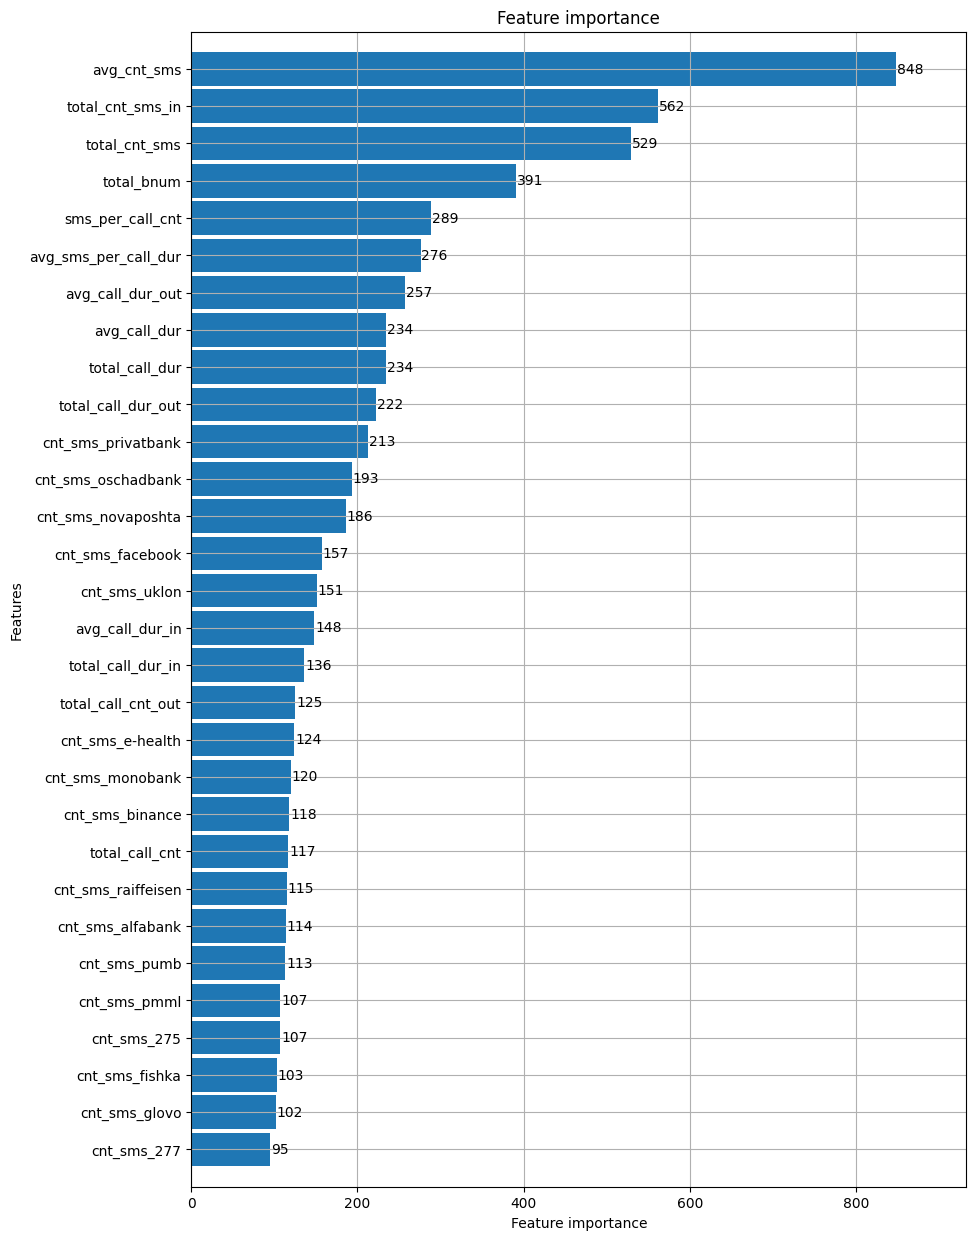

In [27]:
lgb.plot_importance(
    model_bnum_initial,
    max_num_features=30,
    height=0.9,
    figsize=(10, 15),
)

In [28]:
importance_df = (
    pd.DataFrame(
        {
            "feature": model_bnum_initial.feature_name(),
            "importance": model_bnum_initial.feature_importance(),
        }
    )
    .merge(
        pd.DataFrame(
            X_train.agg(lambda series: series[series > 0].count()),
            columns=["abon_count"],
        ),
        how="left",
        left_on="feature",
        right_index=True,
    )
    .sort_values(by="importance", ascending=False)
)
importance_df["coverage"] = importance_df["abon_count"] / len(X_train)

importance_df.describe(percentiles=[0.5, 0.65, 0.75, 0.8, 0.9, 0.95, 0.99])

,importance,abon_count,coverage
count,2719.000000,2719.000000,2719.000000
mean,7.723428,529.853255,0.005114
std,30.730510,5216.078864,0.050347
min,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
65%,0.000000,75.000000,0.000724
75%,5.000000,124.000000,0.001197
80%,8.000000,169.000000,0.001631
90%,19.000000,409.200000,0.003950
95%,34.000000,839.000000,0.008098


In [29]:
def plot_importance_vs_abon_coverage():
    df = importance_df[
        (importance_df["importance"] > 0) | (importance_df["abon_count"] > 0)
    ]

    df_50 = df[df["importance"] >= 50]

    fig = px.bar(
        df_50,
        x="feature",
        y="coverage",
        color="importance",
        log_y=True,
        title=f"Importance >= 50. Features count: {len(df_50)}",
        hover_data=["abon_count"],
    )
    fig.show()

    df_till_50 = df[df["importance"] < 50]

    fig = px.bar(
        df_till_50,
        x="feature",
        y="coverage",
        color="importance",
        log_y=True,
        title=f"0 < Importance < 50. Features count: {len(df_till_50)}",
        hover_data=["abon_count"],
    )
    fig.show()

    df_most_abon = df[(df["importance"] > 0) & (df["coverage"] >= 0.05)]

    fig = px.bar(
        df_most_abon,
        x="feature",
        y="coverage",
        color="importance",
        log_y=True,
        title=f"Importance > 0 and coverage >= 5%. Features count: {len(df_most_abon)}",
        hover_data=["abon_count"],
    )
    fig.show()

    df_dropped = df[(df["importance"] >= 50) & (df["coverage"] < 0.05)].sort_values(
        by="coverage", ascending=False
    )
    print("Imporant features with low coverage we've dropped:")
    print(df_dropped)


plot_importance_vs_abon_coverage()

Imporant features with low coverage we've dropped:
                  feature  importance  abon_count  coverage
2058         cnt_sms_pumb         113        4691  0.045279
2493   cnt_sms_ukrgasbank          74        3269  0.031553
426     cnt_sms_apteka911          54        3194  0.030830
1896     cnt_sms_otp_bank          91        3170  0.030598
1659    cnt_sms_microsoft          84        3086  0.029787
1974         cnt_sms_pmml         107        3074  0.029671
1470     cnt_sms_kyivstar          64        3038  0.029324
315        cnt_sms_a-bank          53        3005  0.029005
1278    cnt_sms_infoshina          70        2690  0.025965
2262   cnt_sms_sport_life          82        2680  0.025868
2616     cnt_sms_whatsapp          53        2659  0.025666
408         cnt_sms_apple          93        2620  0.025289
2628          cnt_sms_wog          53        2573  0.024835
471       cnt_sms_authmsg          55        2464  0.023783
2202        cnt_sms_silpo          62        2403

In [30]:
def calc_permutation():
    class LgbAdapter:
        def __init__(self, predict: callable):
            self.do_predict = predict

        def fit(self):
            raise Exception("Unexpected fit call")

        def predict(self, df):
            return self.do_predict(df)

    p_importance_result = permutation_importance(
        LgbAdapter(predict_bnum_initial),
        X_test,
        y_test,
        scoring=["accuracy"],
        n_jobs=3,
        random_state=RANDOM_SEED,
    )

    return pd.concat(
        [
            pd.DataFrame(
                {
                    "feature": X_test.columns,
                    "mean": p_importance_result["accuracy"]["importances_mean"],
                    "std": p_importance_result["accuracy"]["importances_std"],
                },
            ),
            pd.DataFrame(
                p_importance_result["accuracy"]["importances"],
                columns=["run1", "run2", "run3", "run4", "run5"],
            ),
        ],
        axis=1,
    )


p_imp_df = io.run_cached("./data/bnum_permutation_importance.parquet", calc_permutation)


p_imp_df["p_importance%"] = p_imp_df["mean"] / p_imp_df["mean"].sum() * 100
p_imp_df["importance_tree%"] = (
    importance_df["importance"] / importance_df["importance"].sum() * 100
)
p_imp_df = p_imp_df.merge(
    importance_df.rename(columns={"importance": "importance_tree"}),
    how="left",
    on="feature",
).sort_values(by="mean", ascending=False)

In [31]:
p_imp_df[p_imp_df["mean"] > 0].sort_values(by="mean", ascending=False)

,feature,mean,std,run1,run2,run3,run4,run5,p_importance%,importance_tree%,importance_tree,abon_count,coverage
2031,cnt_sms_privatbank,8.531442e-03,0.000537,0.009266,0.007765,0.008436,0.008979,0.008212,4.094087e+00,1.014286,213,22064,0.212969
2718,total_bnum,7.406697e-03,0.001085,0.007797,0.008436,0.006007,0.006231,0.008563,3.554342e+00,1.861905,391,103602,1.000000
1005,cnt_sms_facebook,6.742076e-03,0.000566,0.006838,0.007285,0.005656,0.006870,0.007062,3.235402e+00,0.747619,157,9502,0.091716
1887,cnt_sms_oschadbank,6.633436e-03,0.000920,0.006646,0.006103,0.007892,0.007285,0.005240,3.183268e+00,0.919048,193,13825,0.133443
2478,cnt_sms_uklon,6.205266e-03,0.000485,0.007030,0.006327,0.005783,0.006231,0.005656,2.977797e+00,0.719048,151,7521,0.072595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,cnt_sms_4567889,1.110223e-17,0.000083,0.000160,0.000000,-0.000064,-0.000032,-0.000064,5.327763e-15,0.014286,3,456,0.004401
1704,cnt_sms_money.4.yo,1.110223e-17,0.000083,0.000032,-0.000128,0.000128,0.000000,-0.000032,5.327763e-15,0.023810,5,286,0.002761
1356,cnt_sms_jti_partner,1.110223e-17,0.000067,0.000128,-0.000064,0.000000,-0.000032,-0.000032,5.327763e-15,0.057143,12,90,0.000869
1290,cnt_sms_int-magazi,1.110223e-17,0.000067,0.000000,-0.000064,-0.000032,0.000128,-0.000032,5.327763e-15,0.042857,9,124,0.001197


In [32]:
px.scatter(
    p_imp_df,
    x="p_importance%",
    y="importance_tree%",
    color="coverage",
    hover_data=["feature"],
    color_continuous_scale="matter",
)

In [33]:
print(
    [
        p_imp_df[p_imp_df["p_importance%"] < 0.5]["p_importance%"].sum(),
        p_imp_df[p_imp_df["p_importance%"] < 0.5]["p_importance%"].count(),
    ]
)

print(
    [
        p_imp_df[p_imp_df["p_importance%"] >= 0.5]["p_importance%"].sum(),
        p_imp_df[p_imp_df["p_importance%"] >= 0.5]["p_importance%"].count(),
    ]
)

[39.94418547595926, 2676]
[60.05581452404074, 43]


In [34]:
def visualize_p_imp():
    df = p_imp_df[p_imp_df["mean"] > 0].sort_values(by="mean", ascending=False)

    fig = px.bar(
        df,
        x="feature",
        y="p_importance%",
        color="coverage",
        title=f"Prediction contribution by feature. Features count: {len(df)}",
        hover_data=["abon_count", "mean", "std", "importance_tree"],
        width=1000,
    )
    fig.show()

    df_coverage = df[(df["coverage"] >= 0.01) | (df["p_importance%"] >= 0.01)]

    fig = px.bar(
        df,
        x="feature",
        y="coverage",
        color="p_importance%",
        title=f"Subscriber coverage by feature. Features count: {len(df_coverage)}",
        hover_data=["abon_count", "mean", "std", "importance_tree"],
        width=1000,
    )
    fig.show()


visualize_p_imp()

In [35]:
def plot_p_imp():
    df = p_imp_df[p_imp_df["p_importance%"] >= 0.5].sort_values(by="mean", ascending=False)
    df = pd.DataFrame(
        df[["run1", "run2", "run3", "run4", "run5"]].T.values,
        columns=df["feature"].to_list(),
    )

    return px.box(
        df,
        x=df.columns.to_list(),
        height=500,
    )
    # df.plot.box(vert=False, whis=10)


plot_p_imp()

In [36]:
def train_topk_features(k: float):
    df_topk = p_imp_df.nlargest(int(k), columns=["mean"])["feature"]
    feature_count = len(df_topk)

    print(f"\n\n=== Training on top {feature_count} features ===")

    X_train_pruned = X_train[df_topk.values]
    X_test_pruned = X_test[df_topk.values]

    predict_bnum_pruned, model_bnum_pruned = model_lgb.train_multiclass(
        X_train=X_train_pruned,
        y_train=y_train,
        X_test=X_test_pruned,
        y_test=y_test,
        # use params from one of the latest optuna runs
        params={
            "eta": 0.14500888302521245,
            "boosting_type": "gbdt",
            "lambda_l1": 5.230968326696493e-05,
            "lambda_l2": 0.11699075404483424,
            "num_leaves": 43,
            "min_data_in_leaf": 40,
            "feature_fraction": 0.6663504423131371,
            "bagging_fraction": 0.841006151751639,
            "bagging_freq": 2,
            "verbosity": -1,
        },
        num_class=CLASS_NUM,
        seed=RANDOM_SEED,
    )

    print(f"Train dataset for {len(df_topk)} features:")
    report_train = project_api.report(
        y_test=y_train,
        y_pred=predict_bnum_pruned(X_train_pruned),
    )

    print(f"\nTest dataset for {len(df_topk)} features:")
    report_test = project_api.report(
        y_test=y_test,
        y_pred=predict_bnum_pruned(X_test_pruned),
    )

    return (feature_count, report_train["accuracy"], report_test["accuracy"])


def profile_feature_counts():
    result = {
        "feature_count": [],
        "accuracy_train": [],
        "accuracy_test": [],
    }
    total_features = len(p_imp_df)

    for topk_value in [
        total_features * 1,
        total_features * 0.75,
        total_features * 0.5,
        total_features * 0.25,
        400,
        300,
        200,
        100,
        75,
        50,
        40,
        20,
        10,
    ]:
        feature_count, accuracy_train, accuracy_test = train_topk_features(topk_value)

        result["feature_count"].append(feature_count)
        result["accuracy_train"].append(accuracy_train)
        result["accuracy_test"].append(accuracy_test)

    return pd.DataFrame(result)


df_feature_count_profile = io.run_cached(
    "./data/bnum_feature_count_vs_acc.parquet", profile_feature_counts
)
df_feature_count_profile

,feature_count,accuracy_train,accuracy_test
0,2719,0.482056,0.395482
1,2039,0.479904,0.399348
2,1359,0.478852,0.399636
3,679,0.478456,0.398965
4,400,0.477356,0.396568
5,300,0.469914,0.393405
6,200,0.461873,0.386343
7,100,0.427762,0.375320
8,75,0.415726,0.364232
9,50,0.398380,0.353783


In [37]:
px.line(
    df_feature_count_profile,
    x="feature_count",
    y=["accuracy_train", "accuracy_test"],
    title="Accuracy vs feature count",
    labels={"feature_count": "Feature acount", "value": "Accuracy"},
    markers=".",
    log_x=True,
)

On the graph above we can see a plateau from 400 till 2719, therefore the most value is in the first 400 features. Lets pick one model with lower feature count and another one with higher and compare which one will perform better with the main dataset.

The models we are selecting:

- 300 features, 0.393 accuracy, 88.97% features dropped
- 40 features, 0.351 accuracy, 98.53% features dropped

## Export models and feature data to use with main dataset

In [38]:
top40_features_path = "./data/bnum_top40_features.json"
top300_features_path = "./data/bnum_top300_features.json"
io.write_json(
    top40_features_path,
    p_imp_df.nlargest(40, columns=["mean"])["feature"].to_list(),
)
io.write_json(
    top300_features_path,
    p_imp_df.nlargest(300, columns=["mean"])["feature"].to_list(),
)

In [39]:
def train_model_on_top_features(
    study_name: str,
    feature_selection_path: str,
):
    # just reuse previous dataset but select only top features
    X_train, y_train = bnum.preprocess(
        name="bnum_initial_train",
        bnum_path="./data/train_num",
        fe_path="./data/train_fe/",
        bnum_selection_path=bnum_selection_path,
        feature_selection_path=feature_selection_path,
    )
    X_test, y_test = bnum.preprocess(
        name="bnum_initial_test",
        bnum_path="./data/test_num",
        fe_path="./data/test_fe/",
        bnum_selection_path=bnum_selection_path,
        feature_selection_path=feature_selection_path,
    )

    print(f"Train X: {X_train.shape}")
    print(f"Train y: {y_train.shape}")
    print(f"Test X: {X_test.shape}")
    print(f"Test y: {y_test.shape}")

    study = project_api.train_lgb(
        study_name=study_name,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

    predict_bnum, model_bnum = model_lgb.train_multiclass(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        params=study.best_params,
        num_class=CLASS_NUM,
        seed=RANDOM_SEED,
        name=f"2024_06_12_{study_name}",
    )

    print("Train dataset:")
    project_api.report(
        y_test=y_train,
        y_pred=predict_bnum(X_train),
    )

    print("\n\nTest dataset:")
    project_api.report(
        y_test=y_test,
        y_pred=predict_bnum(X_test),
    )

In [40]:
# Best hyperparameters:  {'eta': 0.09567079784433358, 'boosting_type': 'gbdt', 'lambda_l1': 1.5210916565448715e-05, 'lambda_l2': 0.0016421818989696046, 'num_leaves': 20, 'min_data_in_leaf': 20, 'feature_fraction': 0.5059494983135318, 'bagging_fraction': 0.9264620752193855, 'bagging_freq': 1}
# Best score:  0.35247315950920244
train_model_on_top_features(
    study_name="bnum_top40_acc_351",
    feature_selection_path=top40_features_path,
)

Train X: (103602, 40)
Train y: (103602, 1)
Test X: (31296, 40)
Test y: (31296, 1)


[I 2024-06-12 00:09:51,056] A new study created in RDB with name: bnum_top40_acc_351
[I 2024-06-12 00:11:10,528] Trial 0 finished with value: 0.27140848670756645 and parameters: {'eta': 9.915644566638385e-06, 'boosting_type': 'gbdt', 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'num_leaves': 9, 'min_data_in_leaf': 0, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'bagging_freq': 5}. Best is trial 0 with value: 0.27140848670756645.
[I 2024-06-12 00:12:35,363] Trial 1 finished with value: 0.27140848670756645 and parameters: {'eta': 1.4610865886287176e-08, 'boosting_type': 'gbdt', 'lambda_l1': 8.148018307012941e-07, 'lambda_l2': 4.329370014459266e-07, 'num_leaves': 10, 'min_data_in_leaf': 10, 'feature_fraction': 0.7148538589793427, 'bagging_fraction': 0.6591670111852694, 'bagging_freq': 3}. Best is trial 0 with value: 0.27140848670756645.
/home/sleepwalker/.local/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning

Best hyperparameters:  {'eta': 0.09567079784433358, 'boosting_type': 'gbdt', 'lambda_l1': 1.5210916565448715e-05, 'lambda_l2': 0.0016421818989696046, 'num_leaves': 20, 'min_data_in_leaf': 20, 'feature_fraction': 0.5059494983135318, 'bagging_fraction': 0.9264620752193855, 'bagging_freq': 1}
Best score:  0.35247315950920244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2423
[LightGBM] [Info] Number of data points in the train set: 103602, number of used features: 40
[LightGBM] [Info] Start training from score -2.152654
[LightGBM] [Info] Start training from score -1.656492
[LightGBM] [Info] Start training from score -1.298190
[LightGBM] [Info] Start training from score -1.506237
[LightGBM] [Info] Start training from score -1.618231
Train dataset:
Accuracy: 0.37814907048126484


Test dataset:
Accuracy: 0.35247315950920244


In [41]:
# Best hyperparameters:  {'eta': 0.1781167554876789, 'boosting_type': 'gbdt', 'lambda_l1': 0.0002301539270262026, 'lambda_l2': 3.1265982077766114e-07, 'num_leaves': 23, 'min_data_in_leaf': 30, 'feature_fraction': 0.5156435883074129, 'bagging_fraction': 0.594480400599395, 'bagging_freq': 3}
# Best score:  0.39410787321063395
train_model_on_top_features(
    study_name="bnum_top300_acc_3934",
    feature_selection_path=top300_features_path,
)

Train X: (103602, 300)
Train y: (103602, 1)
Test X: (31296, 300)
Test y: (31296, 1)


[I 2024-06-12 00:25:15,495] A new study created in RDB with name: bnum_top300_acc_3934
[I 2024-06-12 00:25:23,211] Trial 0 finished with value: 0.27140848670756645 and parameters: {'eta': 9.915644566638385e-06, 'boosting_type': 'gbdt', 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'num_leaves': 9, 'min_data_in_leaf': 0, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'bagging_freq': 5}. Best is trial 0 with value: 0.27140848670756645.
[I 2024-06-12 00:25:31,300] Trial 1 finished with value: 0.27140848670756645 and parameters: {'eta': 1.4610865886287176e-08, 'boosting_type': 'gbdt', 'lambda_l1': 8.148018307012941e-07, 'lambda_l2': 4.329370014459266e-07, 'num_leaves': 10, 'min_data_in_leaf': 10, 'feature_fraction': 0.7148538589793427, 'bagging_fraction': 0.6591670111852694, 'bagging_freq': 3}. Best is trial 0 with value: 0.27140848670756645.
/home/sleepwalker/.local/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarni

Best hyperparameters:  {'eta': 0.1781167554876789, 'boosting_type': 'gbdt', 'lambda_l1': 0.0002301539270262026, 'lambda_l2': 3.1265982077766114e-07, 'num_leaves': 23, 'min_data_in_leaf': 30, 'feature_fraction': 0.5156435883074129, 'bagging_fraction': 0.594480400599395, 'bagging_freq': 3}
Best score:  0.39410787321063395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7735
[LightGBM] [Info] Number of data points in the train set: 103602, number of used features: 300
[LightGBM] [Info] Start training from score -2.152654
[LightGBM] [Info] Start training from score -1.656492
[LightGBM] [Info] Start training from score -1.298190
[LightGBM] [Info] Start training from score -1.506237
[LightGBM] [Info] Start training from score -1.618231
Train dataset:
Accuracy: 0.4414103974826741


Test da